In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%matplotlib inline

# 1. Getting CelebA
---
* Download from Kaggle
* Unzip into 'celeba-dataset\' folder

In [0]:
# ------------------------------------------------------------------------------
# -- Downloading CelebA
# ------------------------------------------------------------------------------

!pip install kaggle

os.environ['KAGGLE_USERNAME'] = "YOUR_USERNAME"
os.environ['KAGGLE_KEY'] = "YOUR_API_KEY"

!kaggle datasets download -d jessicali9530/celeba-dataset

In [0]:
# ------------------------------------------------------------------------------
# -- unzipping and storing to 'celeba-folder'
# ------------------------------------------------------------------------------

import zipfile

def extract(path, folder):
  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(folder)
  zip_ref.close()

base_folder = 'celeba-dataset'
extract(base_folder + ".zip", base_folder)

for file in os.listdir(base_folder):
  name, ext = os.path.splitext(file)
  if ext == ".zip":
    extract(os.path.join(base_folder, file), base_folder)

# 2. Data Exploration
---
* Wrapping the dataset into the CelebA class
* Getting some info about the dataset (num samples, available attributes, ...)
* Showing some example samples
* Analyzing the features frequencies

In [0]:
# ------------------------------------------------------------------------------
# -- CelebA Class:
# ------------------------------------------------------------------------------

class CelebA():
  '''Wraps the celebA dataset, allowing an easy way to:
       - Select the features of interest,
       - Split the dataset into 'training', 'test' or 'validation' partition.
  '''
  def __init__(self, main_folder='celeba-dataset/', selected_features=None, drop_features=[]):
    self.main_folder = main_folder
    self.images_folder   = os.path.join(main_folder, 'img_align_celeba/')
    self.attributes_path = os.path.join(main_folder, 'list_attr_celeba.csv')
    self.partition_path  = os.path.join(main_folder, 'list_eval_partition.csv')
    self.selected_features = selected_features
    self.features_name = []
    self.__prepare(drop_features)

  def __prepare(self, drop_features):
    '''do some preprocessing before using the data: e.g. feature selection'''
    # attributes:
    if self.selected_features is None:
      self.attributes = pd.read_csv(self.attributes_path)
      self.num_features = 40
    else:
      self.num_features = len(self.selected_features)
      self.selected_features = self.selected_features.copy()
      self.selected_features.append('image_id')
      self.attributes = pd.read_csv(self.attributes_path)[self.selected_features]

    # remove unwanted features:
    for feature in drop_features:
      if feature in self.attributes:
        self.attributes = self.attributes.drop(feature, axis=1)
        self.num_features -= 1
      
    self.attributes.set_index('image_id', inplace=True)
    self.attributes.replace(to_replace=-1, value=0, inplace=True)
    self.attributes['image_id'] = list(self.attributes.index)
  
    self.features_name = list(self.attributes.columns)[:-1]
  
    # load ideal partitioning:
    self.partition = pd.read_csv(self.partition_path)
    self.partition.set_index('image_id', inplace=True)
  
  def split(self, name='training', drop_zero=False):
    '''Returns the ['training', 'validation', 'test'] split of the dataset'''
    # select partition split:
    if name is 'training':
      to_drop = self.partition.where(lambda x: x != 0).dropna()
    elif name is 'validation':
      to_drop = self.partition.where(lambda x: x != 1).dropna()
    elif name is 'test':  # test
      to_drop = self.partition.where(lambda x: x != 2).dropna()
    else:
      raise ValueError('CelebA.split() => `name` must be one of [training, validation, test]')

    partition = self.partition.drop(index=to_drop.index)
      
    # join attributes with selected partition:
    joint = partition.join(self.attributes, how='inner').drop('partition', axis=1)

    if drop_zero is True:
      # select rows with all zeros values
      return joint.loc[(joint[self.features_name] == 1).any(axis=1)]
    elif 0 <= drop_zero <= 1:
      zero = joint.loc[(joint[self.features_name] == 0).all(axis=1)]
      zero = zero.sample(frac=drop_zero)
      return joint.drop(index=zero.index)

    return joint


In [0]:
# listing available features with correspondind label (numeric identifier):

print("CelebA Facial Attributes:")

for index, attribute_name in enumerate(CelebA().attributes.columns[:-1]):
  print(f"{index}: {attribute_name}")

CelebA Facial Attributes:
0: 5_o_Clock_Shadow
1: Arched_Eyebrows
2: Attractive
3: Bags_Under_Eyes
4: Bald
5: Bangs
6: Big_Lips
7: Big_Nose
8: Black_Hair
9: Blond_Hair
10: Blurry
11: Brown_Hair
12: Bushy_Eyebrows
13: Chubby
14: Double_Chin
15: Eyeglasses
16: Goatee
17: Gray_Hair
18: Heavy_Makeup
19: High_Cheekbones
20: Male
21: Mouth_Slightly_Open
22: Mustache
23: Narrow_Eyes
24: No_Beard
25: Oval_Face
26: Pale_Skin
27: Pointy_Nose
28: Receding_Hairline
29: Rosy_Cheeks
30: Sideburns
31: Smiling
32: Straight_Hair
33: Wavy_Hair
34: Wearing_Earrings
35: Wearing_Hat
36: Wearing_Lipstick
37: Wearing_Necklace
38: Wearing_Necktie
39: Young


In [0]:
# selecting 37 out of 40 features

celeba = CelebA(drop_features=[
    'Attractive',
    'Pale_Skin',
    'Blurry',
])

# couting number of samples per partition:
print(f"total entries: {celeba.attributes.shape[0]}")
print(f"  - training: {celeba.split('training').shape[0]}")
print(f"  - validation: {celeba.split('validation').shape[0]}")
print(f"  - test: {celeba.split('test').shape[0]}")

total entries: 202599
  - training: 162770
  - validation: 19867
  - test: 19962


In [0]:
# shows five random samples
celeba.attributes.sample(5)

,5_o_Clock_Shadow,Arched_Eyebrows,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,image_id
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
146596.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,146596.jpg
027415.jpg,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,027415.jpg
031426.jpg,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,031426.jpg
027743.jpg,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,027743.jpg
108558.jpg,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,0,1,108558.jpg


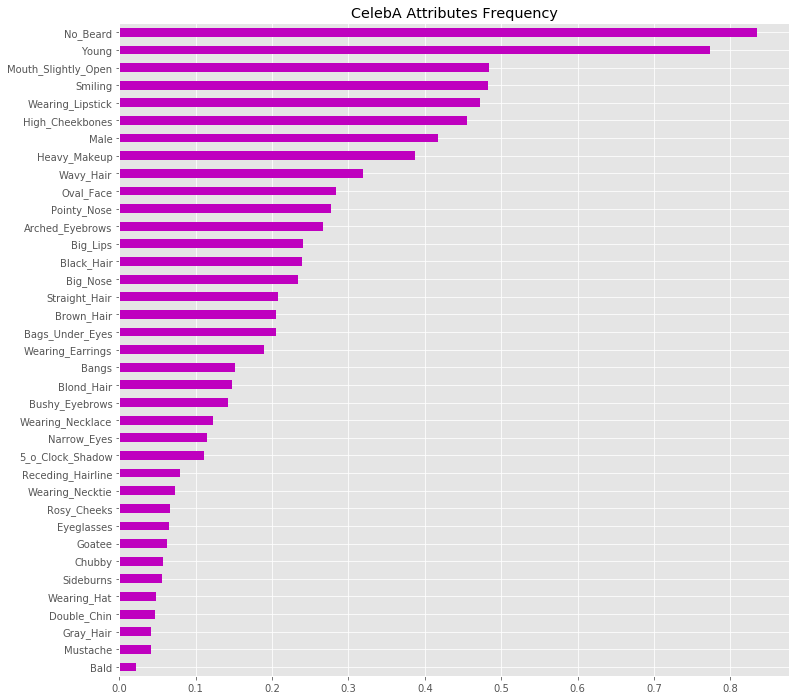

In [0]:
# ------------------------------------------------------------------------------
# -- Computing sorted features frequency on all the 202k entries
# ------------------------------------------------------------------------------

frequencies = celeba.attributes.mean(axis=0).sort_values()

_ = frequencies.plot(title='CelebA Attributes Frequency', 
                     kind='barh', 
                     figsize=(12, 12),
                     color='m')

path: 'celeba-dataset/img_align_celeba/126341.jpg'
attributes: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1]


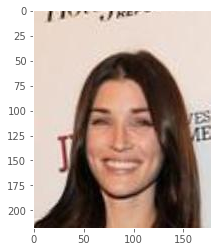

,5_o_Clock_Shadow,Arched_Eyebrows,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
126341.jpg,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1


In [0]:
# ------------------------------------------------------------------------------
# -- Shows a random sample image with its attributes:
# ------------------------------------------------------------------------------

import cv2 

# pick a sample
random_sample = celeba.attributes.sample(1)
pic_path = os.path.join(celeba.images_folder, random_sample.index[0])

print(f"path: '{pic_path}'")
print(f"attributes: {random_sample.to_numpy()[0, :-1]}")

# load and convert the image
pic = cv2.imread(pic_path)
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)

# plot with attributes
plt.imshow(pic)
plt.grid(False)
plt.show()

random_sample.drop('image_id', axis=1)